In [111]:
import numpy as np
import pandas as pd

df = pd.read_csv('all-ratios-quarterly.csv')

In [112]:
df.head()

,Ticker,Unnamed: 1,12/31/1995,3/31/1996,6/30/1996,9/30/1996,12/31/1996,3/31/1997,6/30/1997,9/30/1997,...,6/30/2022,9/30/2022,12/31/2022,3/31/2023,6/30/2023,9/30/2023,12/31/2023,3/31/2024,6/30/2024,9/30/2024
0,ALL,Market Capitalization,NaN,NaN,NaN,NaN,25521,26183,31761,34863,...,34849,33660,35962,29180,28661,29142,36631,45513,42137,50877
1,ALL,Market Cap Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.75%,-10.58%,6.63%,-24.31%,-17.75%,-13.42%,1.86%,55.98%,47.02%,47.02%
2,ALL,Enterprise Value,1138,NaN,NaN,NaN,26791,27386,32990,36169,...,42053,40841,43190,36970,35911,36228,43851,52601,49620,60343
3,ALL,PE Ratio,NaN,NaN,NaN,NaN,12.3,10.83,13.83,12.32,...,38.42,-117.69,-25.8,-12.29,-10.53,-14.02,-115.92,37.34,14.49,17.53
4,ALL,PS Ratio,NaN,NaN,NaN,NaN,1.05,1.07,1.31,1.41,...,0.7,0.66,0.7,0.55,0.53,0.52,0.64,0.78,0.7,0.84


In [113]:
df_long = df.melt(id_vars=['Ticker', 'Unnamed: 1'], var_name='Date', value_name='Value')
df_long.columns = ['Ticker', 'Metric', 'Date', 'Value']
df_long['Date'] = pd.to_datetime(df_long['Date'], format='%m/%d/%Y')
df_long = df_long.sort_values(by=['Ticker', 'Date']).dropna().reset_index()

In [114]:
df_long

,index,Ticker,Metric,Date,Value
0,2,ALL,Enterprise Value,1995-12-31,1138
1,8,ALL,Debt / Equity Ratio,1995-12-31,0.1
2,11,ALL,Dividend Yield,1995-12-31,1.90%
3,14,ALL,Total Shareholder Return,1995-12-31,1.90%
4,24,ALL,Interest Coverage,1996-03-31,23.91
...,...,...,...,...,...
1686,1734,ALL,Interest Coverage,2024-09-30,10.5
1687,1736,ALL,Dividend Yield,2024-09-30,1.91%
1688,1737,ALL,Payout Ratio,2024-09-30,33.46%
1689,1738,ALL,Buyback Yield / Dilution,2024-09-30,0.17%


In [115]:
import matplotlib.pyplot as plt
interest_coverage_data = df_long[df_long['Metric'] == 'Interest Coverage']
interest_coverage_data = interest_coverage_data.sort_values('Date')

# Step 3: Set Date as the index
interest_coverage_data.set_index('Date', inplace=True)

# Step 4: Select the Ticker you want to forecast (e.g., 'ALL')
ticker_data = interest_coverage_data[interest_coverage_data['Ticker'] == 'ALL']['Value']

# Convert the Value column to numeric
ticker_data = pd.to_numeric(ticker_data, errors='coerce')

ticker_data


Date
1996-03-31    23.91
1996-06-30    44.75
1996-09-30    13.63
1996-12-31    34.92
1997-03-31    46.17
              ...  
2023-09-30     0.75
2023-12-31    18.09
2024-03-31    16.30
2024-06-30     5.22
2024-09-30    10.50
Name: Value, Length: 115, dtype: float64

In [116]:
# Step 5: Function to create supervised data
def create_supervised_data(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [117]:
#
import plotly.graph_objects as go
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Assuming ticker_data is your time series (Pandas Series or DataFrame with a datetime index)

# Step 6: Scale the data and create supervised data
scaler = MinMaxScaler(feature_range=(0, 1))
ticker_data_scaled = scaler.fit_transform(ticker_data.values.reshape(-1, 1))
look_back = 3 #can adjust this later

#create supervised data and reshape input to be [samples, time steps, features]
X, Y = create_supervised_data(ticker_data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#Step 7: Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 8: Training the model
model.fit(X, Y, epochs=20, batch_size=1, verbose=2)

# Step 9: Forecasting for future periods
# Predict for the next time steps
future_steps = 3
input_data = ticker_data_scaled[-look_back:].reshape(1, look_back, 1)  # Last 'look_back' data points

# Create a date range for the forecasted periods (2 quarters ahead)
forecast_dates = pd.date_range(ticker_data.index[-1], periods=3, freq='Q')[1:]

# Forecast the next steps
predictions = []
for _ in range(future_steps):
    predicted_value = model.predict(input_data)
    predictions.append(predicted_value)
    
    # Prepare input for the next step prediction by appending the predicted value
    input_data = np.append(input_data[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions back to the original scale
forecast = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create forecast dates
forecast_dates = pd.date_range(ticker_data.index[-1], periods=future_steps+1, freq='Q')[1:]



Epoch 1/20


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



94/94 - 6s - 68ms/step - loss: 0.0359
Epoch 2/20
94/94 - 1s - 7ms/step - loss: 0.0224
Epoch 3/20
94/94 - 1s - 7ms/step - loss: 0.0198
Epoch 4/20
94/94 - 1s - 7ms/step - loss: 0.0197
Epoch 5/20
94/94 - 1s - 7ms/step - loss: 0.0191
Epoch 6/20
94/94 - 1s - 8ms/step - loss: 0.0195
Epoch 7/20
94/94 - 1s - 8ms/step - loss: 0.0194
Epoch 8/20
94/94 - 1s - 13ms/step - loss: 0.0187
Epoch 9/20
94/94 - 1s - 9ms/step - loss: 0.0185
Epoch 10/20
94/94 - 1s - 8ms/step - loss: 0.0181
Epoch 11/20
94/94 - 1s - 8ms/step - loss: 0.0192
Epoch 12/20
94/94 - 1s - 8ms/step - loss: 0.0182
Epoch 13/20
94/94 - 1s - 7ms/step - loss: 0.0188
Epoch 14/20
94/94 - 1s - 8ms/step - loss: 0.0176
Epoch 15/20
94/94 - 1s - 9ms/step - loss: 0.0183
Epoch 16/20
94/94 - 1s - 12ms/step - loss: 0.0175
Epoch 17/20
94/94 - 1s - 9ms/step - loss: 0.0176
Epoch 18/20
94/94 - 1s - 15ms/step - loss: 0.0175
Epoch 19/20
94/94 - 1s - 7ms/step - loss: 0.0167
Epoch 20/20
94/94 - 1s - 8ms/step - loss: 0.0178


C:\Users\alexv\AppData\Local\Temp\ipykernel_4100\3806333759.py:34: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


C:\Users\alexv\AppData\Local\Temp\ipykernel_4100\3806333759.py:49: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



DatetimeIndex(['1996-03-31', '1996-06-30', '1996-09-30', '1996-12-31',
               '1997-03-31', '1997-06-30', '1997-09-30', '1997-12-31',
               '1998-03-31', '1998-06-30',
               ...
               '2022-06-30', '2022-09-30', '2022-12-31', '2023-03-31',
               '2023-06-30', '2023-09-30', '2023-12-31', '2024-03-31',
               '2024-06-30', '2024-09-30'],
              dtype='datetime64[ns]', name='Date', length=115, freq=None)


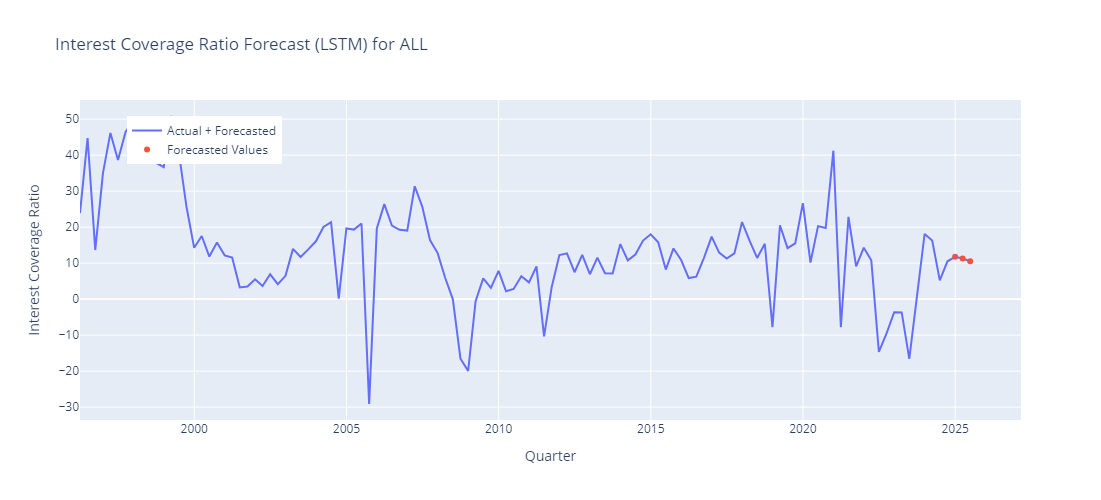

In [118]:
# Step 8: Plot using Plotly
fig = go.Figure()
forecast = forecast.flatten()
print(ticker_data.index)
# Combine actual and forecasted data
combined_values = np.concatenate([ticker_data.values, forecast])

# Create a combined date index (ticker_data's dates + forecast_dates)
combined_dates = pd.concat([pd.Series(ticker_data.index), pd.Series(forecast_dates)])

# Plot combined actual and forecasted data as one continuous line
fig.add_trace(go.Scatter(x=combined_dates, y=combined_values, mode='lines', name='Actual + Forecasted'))

# Highlight forecasted values with markers to distinguish them from actual data
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast, mode='markers', name='Forecasted Values'))

# Add labels and title
fig.update_layout(
    title='Interest Coverage Ratio Forecast (LSTM) for ALL',
    xaxis_title='Quarter',
    yaxis_title='Interest Coverage Ratio',
    legend=dict(x=0.05, y=0.95, traceorder='normal'),
    autosize=False,
    width=800,
    height=500
)

# Show the plot
fig.show()

In [119]:
# Step 8: Print the forecasted value for 2025
print(forecast)

[11.760545 11.268712 10.502725]
